In [135]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sbn
import pandas as pd
import datetime
import time
from pandas.api.types import CategoricalDtype

%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
plt.style.use('default') 
sbn.set(style="whitegrid") 

# **Satinización de archivos de edad y genero**

In [136]:
#Antes que nada, me intriga si los archivos de 'datos_navent' y los de 'hasta15/4' tienen overlap, son redundantes o consecutivos
genero_edad_navent = pd.read_csv('datos/datos_navent/fiuba_2_postulantes_genero_y_edad.csv')
genero_edad_hasta_15_4 = pd.read_csv('datos/hasta_15_4/fiuba_2_postulantes_genero_y_edad.csv')
genero_edad_desde_15_4 = pd.read_csv('datos/desde_15_4/fiuba_2_postulantes_genero_y_edad.csv')
genero_edad_postulantes = genero_edad_navent.merge(genero_edad_hasta_15_4, on=['idpostulante','fechanacimiento','sexo'], how='outer')

In [137]:
print("tamaño archivo navent {}".format(genero_edad_navent.size))
print("tamaño archivo hasta_15_4 {}".format(genero_edad_hasta_15_4.size))
print("tamaño archivo desde_15_4 {}".format(genero_edad_desde_15_4.size))
print("tamaño archivo merge postulantes {}".format(genero_edad_postulantes.size))
def postulantes_str2timestamp(s): # debo
    if type(s) is datetime.datetime:
        return s
    try:
        return datetime.datetime.strptime(s, '%Y-%m-%d')
    except:
        return None
print (genero_edad_postulantes.describe()) #veo que hay repetidos por id
print (genero_edad_postulantes['sexo'].value_counts()) #veo que hay gente (4) con sexo '0'
genero_edad_postulantes.dtypes
# Genero una funcion para satinizar archivos de postulantes_genero_edad
genero_categoria = CategoricalDtype(categories=["MASC","FEM","NO_DECLARA"], ordered=False)
def satinize_postulante_genero_edad(df):
    df['sexo'] = df['sexo'].astype(genero_categoria).fillna("NO_DECLARA")
    df = df.drop_duplicates(subset='idpostulante')
    df['fechanacimiento']= df['fechanacimiento'].map(postulantes_str2timestamp)
    return df
genero_edad_postulantes = satinize_postulante_genero_edad(genero_edad_postulantes)
genero_edad_postulantes.head()

tamaño archivo navent 602664
tamaño archivo hasta_15_4 893241
tamaño archivo desde_15_4 844155
tamaño archivo merge postulantes 1225356
       idpostulante fechanacimiento    sexo
count        408452          388808  408452
unique       408146           16866       4
top         5mq03Vw      1991-06-20     FEM
freq              2              89  204831
FEM           204831
MASC          184593
NO_DECLARA     19024
0.0                4
Name: sexo, dtype: int64


/home/vasectomio/.virtualenv/datos/lib/python3.6/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


idpostulante      fechanacimiento  sexo
0         NM5M  1970-12-03 00:00:00   FEM
1         5awk  1962-12-04 00:00:00   FEM
2         ZaO5  1978-08-10 00:00:00   FEM
3         NdJl  1969-05-09 00:00:00  MASC
4         eo2p  1981-02-16 00:00:00  MASC

## postulaciones

In [138]:
postulaciones = pd.read_csv(
    'datos/datos_navent/fiuba_4_postulaciones.csv'
).merge(pd.read_csv('datos/hasta_15_4/fiuba_4_postulaciones.csv'))
print(postulaciones.size)
print(postulaciones.drop_duplicates().size) #no hay duplicados!
print(postulaciones.head())
def sanitize_postulaciones(df):
    postulaciones['date'] = pd.to_datetime(postulaciones['fechapostulacion']).dt.date
    postulaciones['time'] = pd.to_datetime(postulaciones['fechapostulacion']).dt.time
    return postulaciones.copy()
postulaciones = sanitize_postulaciones(postulaciones)
print(postulaciones.head())

5120190
5120190
      idaviso idpostulante     fechapostulacion
0  1112286523         ZaO5  2018-01-24 15:07:39
1  1112272060         ZaO5  2018-01-24 15:20:10
2  1112288401         ZaO5  2018-01-26 08:37:04
3  1112300563         ZaO5  2018-01-30 13:35:48
4  1112293018         ZaO5  2018-01-31 08:41:05
      idaviso idpostulante     fechapostulacion        date      time
0  1112286523         ZaO5  2018-01-24 15:07:39  2018-01-24  15:07:39
1  1112272060         ZaO5  2018-01-24 15:20:10  2018-01-24  15:20:10
2  1112288401         ZaO5  2018-01-26 08:37:04  2018-01-26  08:37:04
3  1112300563         ZaO5  2018-01-30 13:35:48  2018-01-30  13:35:48
4  1112293018         ZaO5  2018-01-31 08:41:05  2018-01-31  08:41:05


## Archivo 'avisos_detalle'

In [139]:
avisos_detalle = pd.read_csv(
    'datos/datos_navent/fiuba_6_avisos_detalle.csv'
).merge(pd.read_csv('datos/hasta_15_4/fiuba_6_avisos_detalle.csv'))
avisos_detalle.isnull().any()
#ESTE DF TIENE MUCHOS DATOS NULOS EN LAS COLUMNAS DE 'CIUDAD' y 'MAPACALLE'. 
#Decidimos eliminarlas ya que no nos parecieron muy relevantes para el analisis
#idpais solo tiene valor 1, la descripcion nunca es nula
#avisos_detalle.drop('descripcion',1,inplace=True)
tipo_trabajo = CategoricalDtype(
    categories=["Full-time","Part-time","Teletrabajo","Por Horas","Pasantia","Temporario","Por Contrato","Fines de Semana","Primer empleo"],
    ordered=True #de 'mas fijo' a 'menos fijo'
)
avisos_detalle.nombre_area.value_counts()# hay muchas areas, no van a tener su propia categoria
def sanitize_aviso_detalle(df):
    df['tipo_de_trabajo'] = df['tipo_de_trabajo'].astype(tipo_trabajo)
    return df.drop(['ciudad','idpais','mapacalle'],1)
avisos_detalle = sanitize_aviso_detalle(avisos_detalle)

## Archivo 'educacion_postulantes'

In [140]:
educacion_postulantes = pd.read_csv(
    'datos/datos_navent/fiuba_1_postulantes_educacion.csv'
).merge(pd.read_csv('datos/hasta_15_4/fiuba_1_postulantes_educacion.csv'))
educacion_postulantes.isna().any() #no hay nulos
educacion_postulantes.duplicated().value_counts()#ni duplicados

False    137072
dtype: int64

# Genero nivel_educativo, completando el dataframe de postulantes

In [141]:
def generar_nivel_educativo(postulantes, educacion):
    #Considero como nivel educativo el maximo nivel que alcanzaron que fue completado.
    #Descarto estudios en curso o abandonados, quizas deba volver aca en algun momento
    tipo_estudio = CategoricalDtype(
        categories=["Otro","Secundario","Terciario/Técnico","Universitario","Posgrado","Master","Doctorado"],
        ordered=True
    )
    educacion = educacion[educacion.estado=='Graduado'].drop(['estado'],1)
    educacion.nombre= educacion.nombre.astype(tipo_estudio)
    educacion = educacion.sort_values(by='nombre',ascending=True)
    educacion = educacion.drop_duplicates(subset='idpostulante',keep='last')
    postulantes = postulantes.merge(educacion, on='idpostulante')
    postulantes = postulantes.rename(index=str,columns={'nombre':'nivel_educativo'})
    return postulantes.copy()
postulantes = generar_nivel_educativo(genero_edad_postulantes, educacion_postulantes)

## Archivo 'vistas'

In [142]:
vistas.head()
# Plantea la relación entre postulantes y avisos

idAviso                     timestamp idpostulante
0  1111780242  2018-02-23T13:38:13.187-0500      YjVJQ6Z
1  1112263876  2018-02-23T13:38:14.296-0500      BmVpYoR
2  1112327963  2018-02-23T13:38:14.329-0500      wVkBzZd
3  1112318643  2018-02-23T13:38:17.921-0500      OqmP9pv
4  1111903673  2018-02-23T13:38:18.973-0500      DrpbXDP

In [143]:
vistas.isnull().any()

idAviso         False
timestamp       False
idpostulante    False
dtype: bool

In [144]:
vistas.duplicated().any()

False

In [145]:
postulaciones

idaviso idpostulante     fechapostulacion        date      time
0        1112286523         ZaO5  2018-01-24 15:07:39  2018-01-24  15:07:39
1        1112272060         ZaO5  2018-01-24 15:20:10  2018-01-24  15:20:10
2        1112288401         ZaO5  2018-01-26 08:37:04  2018-01-26  08:37:04
3        1112300563         ZaO5  2018-01-30 13:35:48  2018-01-30  13:35:48
4        1112293018         ZaO5  2018-01-31 08:41:05  2018-01-31  08:41:05
5        1112301287         ZaO5  2018-01-31 08:55:20  2018-01-31  08:55:20
6        1112309589         ZaO5  2018-02-03 15:55:15  2018-02-03  15:55:15
7        1112317020         ZaO5  2018-02-07 09:56:22  2018-02-07  09:56:22
8        1112322363         ZaO5  2018-02-09 10:29:54  2018-02-09  10:29:54
9        1112327122         ZaO5  2018-02-11 17:49:26  2018-02-11  17:49:26
10       1112315062         ZaO5  2018-02-11 18:08:14  2018-02-11  18:08:14
11       1112348722         ZaO5  2018-02-21 19:53:24  2018-02-21  19:53:24
12       1112347076         ZaO5  2018-02-21 20:10:19  2018-02-21  20:10:19
13       1112346704         ZaO5  2018-02-21 20:15:35  2018-02-21  20:15:35
14       1112346547         ZaO5  2018-02-21 20:17:29  2018-02-21  20:17:29
15       1112335122         ZaO5  2018-02-21 20:23:19  2018-02-21  20:23:19
16       1112350663         ZaO5  2018-02-21 20:25:29  2018-02-21  20:25:29
17       1112346564         ZaO5  2018-02-21 20:26:54  2018-02-21  20:26:54
18       1112343977         ZaO5  2018-02-21 20:29:24  2018-02-21  20:29:24
19       1112345203         ZaO5  2018-02-21 20:29:54  2018-02-21  20:29:54
20       1112303217         ZaO5  2018-02-21 20:30:29  2018-02-21  20:30:29
21       1112345900         ZaO5  2018-02-21 20:33:00  2018-02-21  20:33:00
22       1112364763         ZaO5  2018-02-27 20:54:50  2018-02-27  20:54:50
23       1112261212         NdJl  2018-01-16 08:50:30  2018-01-16  08:50:30
24       1112273308         NdJl  2018-01-23 07:53:47  2018-01-23  07:53:47
25       1112281548         NdJl  2018-01-24 05:10:12  2018-01-24  05:10:12
26       1112260409         NdJl  2018-01-24 05:17:29  2018-01-24  05:17:29
27       1112293547         NdJl  2018-01-29 15:41:43  2018-01-29  15:41:43
28       1112287915         NdJl  2018-01-29 15:42:39  2018-01-29  15:42:39
29       1112303880         NdJl  2018-01-31 15:16:48  2018-01-31  15:16:48
...             ...          ...                  ...         ...       ...
1706700  1112336254      qe21A9X  2018-02-28 22:30:47  2018-02-28  22:30:47
1706701  1112314018      qe21A9X  2018-02-28 22:35:30  2018-02-28  22:35:30
1706702  1111890741      qe21A9X  2018-02-28 22:39:21  2018-02-28  22:39:21
1706703  1112340866      qe21A9X  2018-02-28 22:40:01  2018-02-28  22:40:01
1706704  1112347055      2zP6J11  2018-02-28 22:22:39  2018-02-28  22:22:39
1706705  1112369432      8MPox8j  2018-02-28 22:52:13  2018-02-28  22:52:13
1706706  1112362468      8MPox8j  2018-02-28 23:26:51  2018-02-28  23:26:51
1706707  1110478766      zvabpEJ  2018-02-28 22:47:13  2018-02-28  22:47:13
1706708  1112186855      8MPoxGz  2018-02-28 22:45:24  2018-02-28  22:45:24
1706709  1112367875      8MPoxGz  2018-02-28 22:55:00  2018-02-28  22:55:00
1706710  1112364777      8MPoxGz  2018-02-28 22:59:25  2018-02-28  22:59:25
1706711  1111636821      8MPoxGz  2018-02-28 23:00:02  2018-02-28  23:00:02
1706712  1111414561      8MPoxGz  2018-02-28 23:02:17  2018-02-28  23:02:17
1706713  1112361855      ow2p8Wr  2018-02-28 22:56:30  2018-02-28  22:56:30
1706714  1112369825      pzdkx1p  2018-02-28 22:38:12  2018-02-28  22:38:12
1706715  1112359807      akjVlK9  2018-02-28 22:51:04  2018-02-28  22:51:04
1706716  1112152590      vVja48E  2018-02-28 22:57:51  2018-02-28  22:57:51
1706717  1112368214      ow2p8vk  2018-02-28 23:13:17  2018-02-28  23:13:17
1706718  1112369739      mzdNo99  2018-02-28 22:59:12  2018-02-28  22:59:12
1706719  1112369774      Nzr1J34  2018-02-28 22:57:20  2018-02-28  22:57:20
1706720  1112369571      Nzr1J34  2018-02-28 23:05:40  2018-

## Arichivo 'avisos_online'

In [146]:
avisos_online.isnull().any()

idaviso    False
dtype: bool

In [147]:
avisos_online.duplicated().any()

False

# Algunas exploraciones de cada archivo por separado

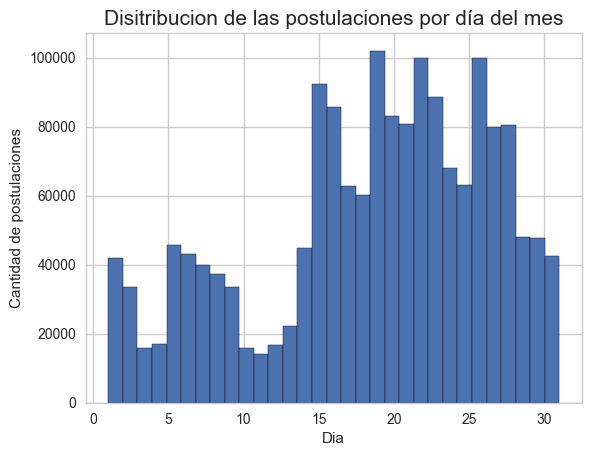

In [148]:
#Distribución de las postulaciones por dia del mes
g_day = pd.to_datetime(postulaciones['date']).dt.day.hist(bins=31,edgecolor='black');
g_day.set_title('Disitribucion de las postulaciones por día del mes',fontsize=15)
g_day.set_xlabel('Dia')
g_day.set_ylabel('Cantidad de postulaciones');

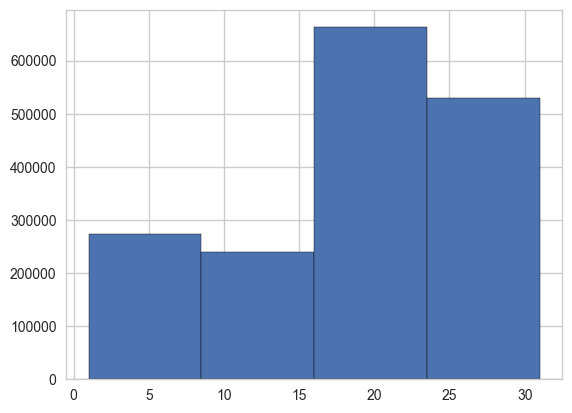

In [149]:
# ¿Será que uno se pone a buscar trabajo cuando se le empieza a acabar el sueldo?
g_day = pd.to_datetime(postulaciones['date']).dt.day.hist(bins=4,edgecolor='black');

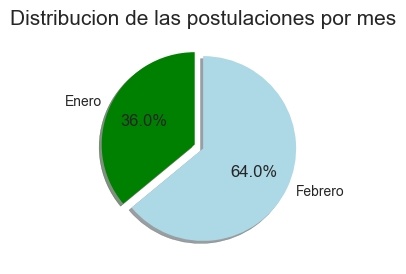

In [150]:
enero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]
enero = pd.DataFrame(enero)

febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero)

sizes = [enero.count(),febrero.count()]
names = ['Enero', 'Febrero']

plt.figure(figsize=(3, 3))
plt.title('Distribucion de las postulaciones por mes', fontsize=15)
plt.pie(sizes, labels=names, autopct='%1.1f%%', startangle=90, colors=['green', 'lightblue'], explode=(0.1, 0),shadow=True)
plt.show()

In [151]:
# ¡Los datos empiezan a partir del 15/1!
postulaciones['date'].min()

datetime.date(2018, 1, 15)

Ambos graficos son engañosos.
El primero muestra que hay mas postulaciones en la segunda mitad de los meses pero eso es porque los datos de Enero son solo de la segunda mitad del mes.
De igual manera el sugundo grafico muestra que Enero tiene practicamente la mitad de postulaciones que Febrero.
Tambien se debe a lo comentado anteriormente, solo hay datos de la segunda mitad de Enero.

In [152]:
#Febrero tiene (casi)los dias completos
febrero = postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]
febrero = pd.DataFrame(febrero.unique()).sort_values(by=0, ascending=False)
febrero

0
9   2018-02-28
5   2018-02-27
8   2018-02-26
26  2018-02-25
24  2018-02-24
11  2018-02-23
13  2018-02-22
4   2018-02-21
17  2018-02-20
16  2018-02-19
25  2018-02-18
7   2018-02-17
23  2018-02-16
15  2018-02-15
14  2018-02-14
6   2018-02-13
27  2018-02-12
3   2018-02-11
22  2018-02-10
2   2018-02-09
21  2018-02-08
1   2018-02-07
20  2018-02-06
19  2018-02-05
18  2018-02-04
0   2018-02-03
10  2018-02-02
12  2018-02-01

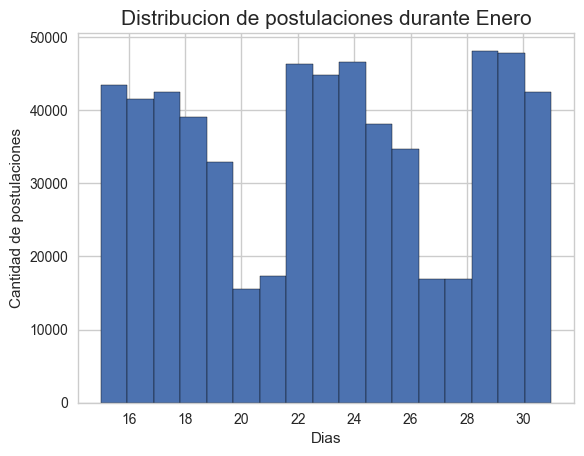

In [153]:
g_month_enero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 1]).dt.day.hist(bins=17,edgecolor='black');
g_month_enero.set_title('Distribucion de postulaciones durante Enero',fontsize=15)
g_month_enero.set_xlabel('Dias')
g_month_enero.set_ylabel('Cantidad de postulaciones');

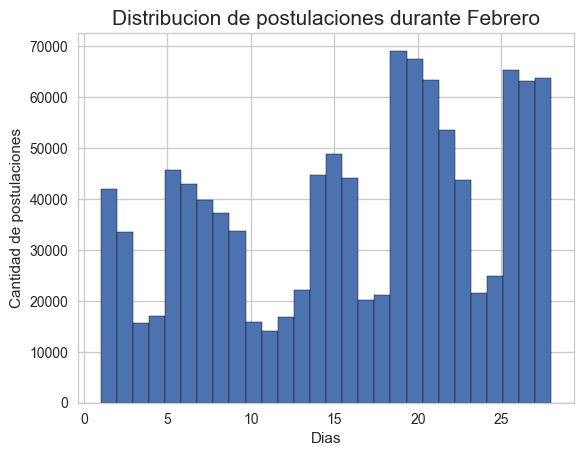

In [154]:
g_month_febrero = pd.to_datetime(postulaciones['date'][pd.to_datetime(postulaciones['date']).dt.month == 2]).dt.day.hist(bins=28,edgecolor='black');
g_month_febrero.set_title('Distribucion de postulaciones durante Febrero',fontsize=15)
g_month_febrero.set_xlabel('Dias')
g_month_febrero.set_ylabel('Cantidad de postulaciones');

Ambos gráficos presentan 'bajones' de 2-3 días de duración: ¿Son fines de semana

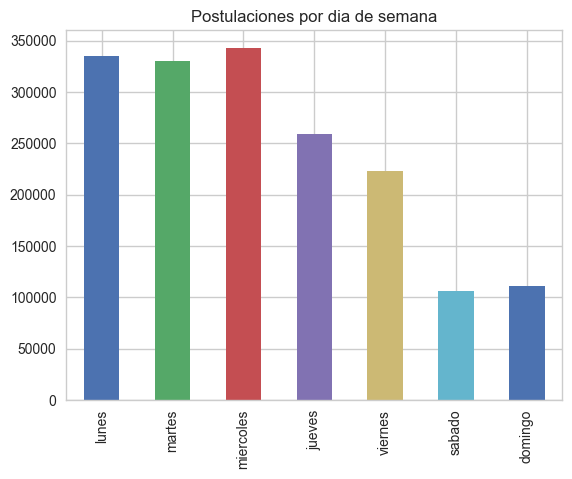

In [155]:
postulaciones['weekday']= pd.to_datetime(postulaciones['date']).dt.dayofweek
days = ['lunes','martes','miercoles','jueves','viernes','sabado','domingo']
postulaciones['weekday'] = pd.Categorical(values=postulaciones['weekday'].values, ordered=True).rename_categories(days)
postulaciones['weekday'].value_counts().sort_index().plot(kind='bar', title='Postulaciones por dia de semana')
# Al hacer el gráfico, podemos ver que los fines de semana tienen muchas menos postulaciones
# y que jueves y viernes son los dias de la semana con menos postulaciones.

In [156]:
#este df contiene solo los dias entre el 15 y 28 de cada mes
enero_febrero_igual_dias = pd.DataFrame(columns = ['date'])
enero_febrero_igual_dias['date'] = postulaciones['date'][(pd.to_datetime(postulaciones['date']).dt.day > 14) & (pd.to_datetime(postulaciones['date']).dt.day < 29)]

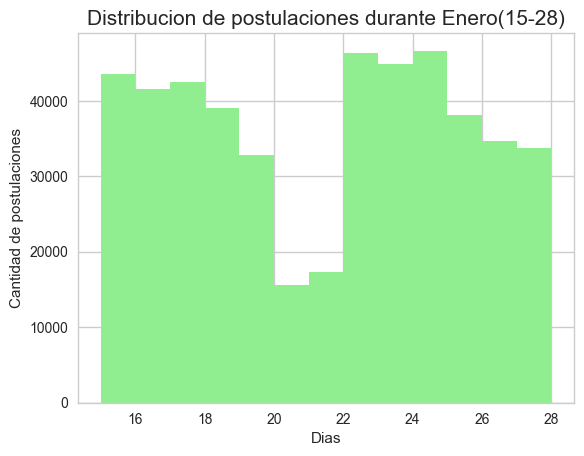

In [157]:
hist_enero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day.hist(bins=13,color= 'lightgreen');
hist_enero_edit.set_title('Distribucion de postulaciones durante Enero(15-28)',fontsize=15)
hist_enero_edit.set_xlabel('Dias')
hist_enero_edit.set_ylabel('Cantidad de postulaciones');

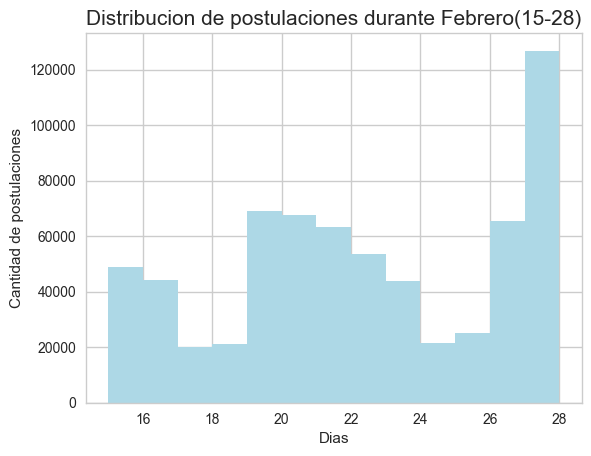

In [158]:
hist_Febrero_edit = pd.to_datetime(enero_febrero_igual_dias['date'][pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day.hist(bins=13,color='lightblue');
hist_Febrero_edit.set_title('Distribucion de postulaciones durante Febrero(15-28)',fontsize=15)
hist_Febrero_edit.set_xlabel('Dias')
hist_Febrero_edit.set_ylabel('Cantidad de postulaciones');

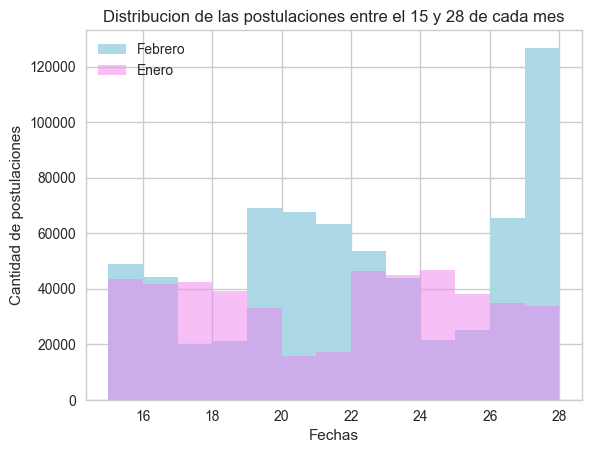

In [159]:
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 2]).dt.day, bins=13,
         color='lightblue',label= 'Febrero')
plt.hist(pd.to_datetime(enero_febrero_igual_dias['date']
        [pd.to_datetime(enero_febrero_igual_dias['date']).dt.month == 1]).dt.day,bins=13,
         color='violet',alpha=0.5, label='Enero')
plt.xlabel('Fechas')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones entre el 15 y 28 de cada mes')
plt.legend()
plt.show()

De esta última comparación se aprecia que el número de postulaciones es en general
mayor para febrero, y que el último día de febrero presenta un pico muy alto en 
las postulaciones.

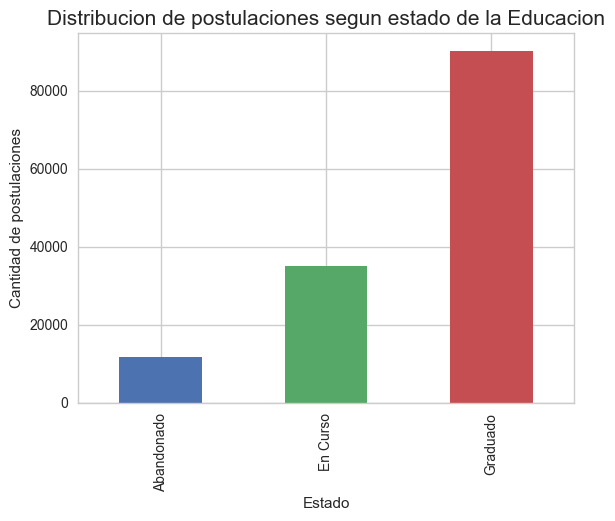

In [160]:
post_educ_estado = educacion_postulantes['estado'].value_counts().sort_index().plot(kind='bar')
post_educ_estado.set_title('Distribucion de postulaciones segun estado de la Educacion',fontsize=15)
post_educ_estado.set_xlabel('Estado')
post_educ_estado.set_ylabel('Cantidad de postulaciones');

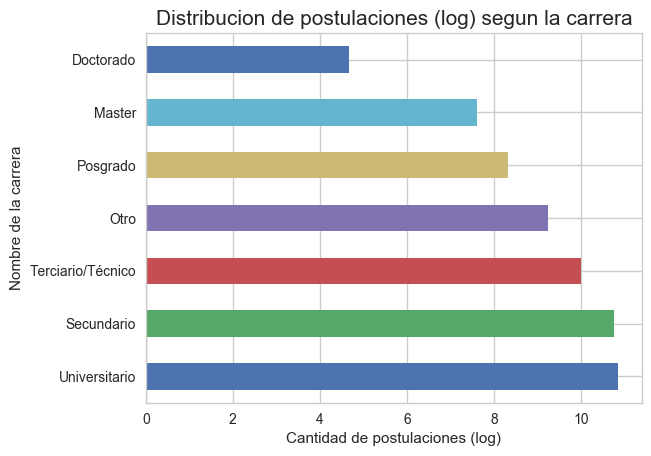

In [161]:
post_educ_carrera = np.log(educacion_postulantes['nombre'].value_counts() + 1).plot(kind='barh')
post_educ_carrera.set_title('Distribucion de postulaciones (log) segun la carrera',fontsize=15)
post_educ_carrera.set_ylabel('Nombre de la carrera')
post_educ_carrera.set_xlabel('Cantidad de postulaciones (log)');

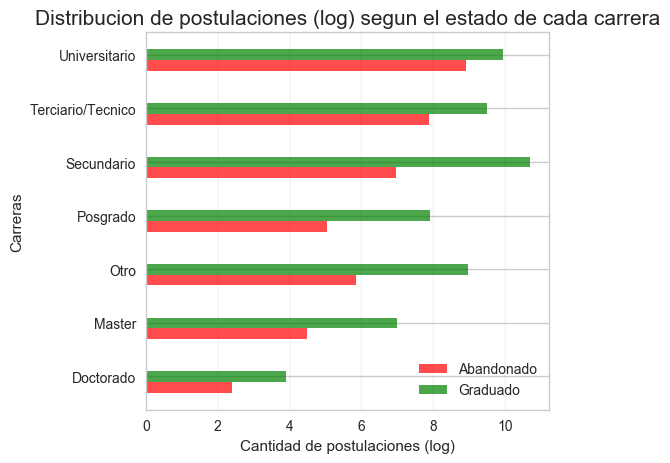

In [162]:
estado_y_carreras = educacion_postulantes[['nombre','estado']]
benchs_number = 7
benchs_names = ['Doctorado','Master','Otro','Posgrado','Secundario', 'Terciario/Tecnico','Universitario']

arch_en_curso = estado_y_carreras[estado_y_carreras['estado'] == 'En Curso']
arch_graduado = estado_y_carreras[estado_y_carreras['estado'] == 'Graduado']
arch_abandonado = estado_y_carreras[estado_y_carreras['estado'] == 'Abandonado']

#Uso una escala logaritmica asi se pueden ver mejor los datos en el grafico
en_curso = np.log(arch_en_curso['nombre'].value_counts() +1).sort_index()
abandonado = np.log(arch_abandonado['nombre'].value_counts() +1).sort_index()
graduado = np.log(arch_graduado['nombre'].value_counts() +1).sort_index()

index = np.arange(len(benchs_names))

bar_width = 0.2
opacity = 0.5

#plt.barh(index, en_curso, bar_width, alpha=0.7,color='y',label='En Curso')
plt.barh(index+bar_width, abandonado, bar_width, alpha=0.7,color='r',label='Abandonado')
plt.barh(index+2*bar_width, graduado, bar_width, alpha=0.7,color='g',label='Graduado')

plt.grid(True, axis='x', linewidth=0.2)
plt.title('Distribucion de postulaciones (log) segun el estado de cada carrera',fontsize = 15)
plt.ylabel('Carreras')
plt.xlabel('Cantidad de postulaciones (log)')
plt.yticks(index + 2*bar_width, benchs_names)
plt.legend()

plt.tight_layout()
plt.show()

In [163]:

genero_edad_postulantes['edad'] = pd.to_datetime(genero_edad_postulantes['fechanacimiento'],errors='coerce').dt.year
genero_edad_postulantes['edad'] = 2018 - genero_edad_postulantes['edad']
genero_edad_postulantes.sort_values(by='edad', ascending=True)

idpostulante      fechanacimiento        sexo  edad
203922        58zak  2008-02-27 00:00:00        MASC  10.0
229609       Y6YaLD  2008-10-01 00:00:00         FEM  10.0
223877       ZOpPMz  2007-01-01 00:00:00        MASC  11.0
6869         a5qWAm  2006-01-01 00:00:00        MASC  12.0
219411       YRZaAr  2006-01-01 00:00:00        MASC  12.0
213644       E4vYO2  2005-05-01 00:00:00        MASC  13.0
205040       ZjWd9b  2004-01-01 00:00:00         FEM  14.0
202236        ZX9Q8  2003-05-18 00:00:00         FEM  15.0
207806       6kKjWL  2002-01-01 00:00:00        MASC  16.0
208198       eRYWkp  2002-01-01 00:00:00         FEM  16.0
207408       NAY2kB  2001-01-01 00:00:00        MASC  17.0
208006       52KWbk  2001-05-17 00:00:00        MASC  17.0
204413       52L6ap  2001-01-01 00:00:00        MASC  17.0
204800       eROLpE  2001-10-16 00:00:00        MASC  17.0
204841       a6j2Gm  2001-02-27 00:00:00        MASC  17.0
205094       8wkrDD  2001-08-18 00:00:00        MASC  17.0
205124       a6ZPjq  2001-01-01 00:00:00         FEM  17.0
205164       ZjR9YE  2001-01-01 00:00:00        MASC  17.0
207466       EDM0jo  2001-01-01 00:00:00        MASC  17.0
205216       8wJBax  2001-05-15 00:00:00        MASC  17.0
205903       1lpzGb  2001-08-06 00:00:00         FEM  17.0
205973       8wQ8Bx  2001-05-15 00:00:00         FEM  17.0
206485       EDreXo  2001-01-01 00:00:00        MASC  17.0
207745       8wKV4R  2001-01-01 00:00:00        MASC  17.0
208292       Zjdq4V  2001-10-10 00:00:00        MASC  17.0
207056       52GAaz  2001-01-01 00:00:00        MASC  17.0
207250       8wGePl  2001-01-01 00:00:00         FEM  17.0
207385       1lGmAb  2001-01-01 00:00:00        MASC  17.0
205853       8w1K3D  2001-01-01 00:00:00        MASC  17.0
206969       8wGPbD  2001-11-07 00:00:00        MASC  17.0
...             ...                  ...         ...   ...
408356      QNrAbEo                 None  NO_DECLARA   NaN
408357      96Xkbz8                 None  NO_DECLARA   NaN
408364      wVkvPzl                 None  NO_DECLARA   NaN
408368      ekOPEp8                 None  NO_DECLARA   NaN
408384      LNK9GBj                 None  NO_DECLARA   NaN
408385      KBrENqd                 None  NO_DECLARA   NaN
408389      NzrvXZl                 None  NO_DECLARA   NaN
408391      vVjoqNx                 None  NO_DECLARA   NaN
408393      ZDrmbB1                 None  NO_DECLARA   NaN
408397      dYjl8Da                 None  NO_DECLARA   NaN
408400      PmGx0eY                 None  NO_DECLARA   NaN
408402      ekOPE8W                 None  NO_DECLARA   NaN
408403      Yj5ePMP                 None  NO_DECLARA   NaN
408404      KBrENLA                 None  NO_DECLARA   NaN
408406      6rPNWOL                 None  NO_DECLARA   NaN
408409      JBrJKQp                 None  NO_DECLARA   NaN
408415      DrXZDMA                 None  NO_DECLARA   NaN
408420      MVrow83                 None  NO_DECLARA   NaN
408422      xkd83qj                 None  NO_DECLARA   NaN
408424      vVjoqvE                 None  NO_DECLARA   NaN
408425      RzrDOG1                 None  NO_DECLARA   NaN
408429      Yj5ePDw                 None  NO_DECLARA   NaN
408434      ow2M3X4                 None  NO_DECLARA   NaN
408435      8MPp03R                 None  NO_DECLARA   NaN
408438      Oqr85l6                 None  NO_DECLARA   NaN
408443      KBrENbq                 None  NO_DECLARA   NaN
408445      EzeaxQ6                 None  NO_DECLARA   NaN
408448      dYjl8Mq                 None  NO_DECLARA   NaN
408449      RzrDOmR                 None  NO_DECLARA   NaN
408451      vVjoqbj                 None  NO_DECLARA   NaN

[408146 rows x 4 columns]

In [164]:
genero_edad_postulantes.fillna(0)
edad_postulantes = pd.DataFrame(columns=['edad'])
edad_postulantes['edad'] = genero_edad_postulantes['edad'][(genero_edad_postulantes['edad'] > 17) & (genero_edad_postulantes['edad'] < 71)]
edad_postulantes['edad'] = edad_postulantes['edad'].astype(int)
edad_postulantes.sort_values(by='edad', ascending = True)

RecursionError: maximum recursion depth exceeded

In [ ]:
genero_edad_postulantes = genero_edad_postulantes.fillna(0)
genero_edad_postulantes['edad'] = genero_edad_postulantes['edad'].astype(int)
genero_edad_postulantes = genero_edad_postulantes[(genero_edad_postulantes['edad'] <71) & (genero_edad_postulantes['edad'] > 17)]
genero_edad_postulantes.head()

In [ ]:
post_genero = genero_edad_postulantes['sexo'].value_counts().plot(kind='barh')
post_genero.set_title('Distribucion de postulantes segun el genero',fontsize=15)
post_genero.set_ylabel('Genero')
post_genero.set_xlabel('Cantidad de postulaciones');

In [ ]:
post_edad = edad_postulantes['edad'].value_counts().sort_index().plot(kind='line',color='green')
post_edad.set_title('Distribucion de postulaciones segun la edad de los postulantes',fontsize=15)
post_edad.set_xlabel('Edad')
post_edad.set_ylabel('Cantidad de postulaciones');



In [ ]:
femenino = pd.DataFrame(columns = ['genero','edad'])
masculino = pd.DataFrame(columns = ['genero','edad'])
no_declara = pd.DataFrame(columns = ['genero','edad'])

femenino = genero_edad_postulantes[genero_edad_postulantes['sexo'] == 'FEM']
masculino = genero_edad_postulantes[genero_edad_postulantes['sexo'] == 'MASC']
no_declara = genero_edad_postulantes[genero_edad_postulantes['sexo'] == 'NO_DECLARA']

#plt.hist(femenino['edad'], bins=53, color='pink',label= 'Postulantes Fememinas')
#plt.hist(masculino['edad'], bins=53, color='darkblue',alpha=0.3, label='Postulantes Masculinos')
#plt.hist(no_declara['edad'], bins=53, color='red',alpha=0.5, label='Postulantes sin sexo declarado')

plt.xlabel('Edad')
plt.ylabel('Cantidad de postulaciones')
plt.title('Distribucion de las postulaciones segun edad y el genero')
plt.legend()
plt.show()

In [ ]:
#Cantidad de postulaciones de personas que no declaran su sexo segun su edad.
no_declara['edad'].value_counts().head()

In [ ]:
avisos_detalle.head()

In [ ]:
#avisos_nivel_laboral = avisos_detalle['nivel_laboral'].value_counts().plot(kind='bar')
#avisos_nivel_laboral.set_title('Distribucion de los avisos laborales segun el nivel laboral pedido',fontsize=15)
#avisos_nivel_laboral.set_xlabel('Cantidad de avisos')
#avisos_nivel_laboral.set_ylabel('Nivel laboral');

avisos_detalle['nivel_laboral'].value_counts()

In [ ]:
avisos_tipo_de_trabajo = np.log(avisos_detalle['tipo_de_trabajo'].value_counts()+1).plot(kind='barh')
avisos_tipo_de_trabajo.set_title('Distribucion de los avisos (log) laborales segun el tipo de trabajo pedido',fontsize=15)
avisos_tipo_de_trabajo.set_ylabel('Tipo de trabajo')
avisos_tipo_de_trabajo.set_xlabel('Cantidad de avisos (log)');

avisos_detalle['tipo_de_trabajo'].value_counts().sum()

In [ ]:
avisos_zona = np.log(avisos_detalle['nombre_zona'].value_counts() + 1).sort_index().plot(kind='bar')
avisos_zona.set_title('Distribucion de los avisos laborales segun la zona de trabajo',fontsize=15)
avisos_zona.set_xlabel('Zona')
avisos_zona.set_ylabel('Cantidad de avisos (log)');

avisos_detalle['nombre_zona'].value_counts()

# Merge de los datos
recuerdo la forma de los datasets

In [ ]:
#vistas = vistas.set_index()
vistas['idpostulante'].value_counts()

In [ ]:
educacion_postulantes.head(15)

In [ ]:
postulantes = genero_edad_postulantes.set_index('idpostulante')
postulantes['anuncios_vistos'] = vistas['idpostulante'].value_counts()
postulantes['anuncios_vistos'] = postulantes['anuncios_vistos'].fillna(0)
#sobresimplificación horrible, habría que ponderar más fuerte estudios avanzados y estudios completos.
postulantes['nivel_educativo'] = educacion_postulantes['idpostulante'].value_counts()

postulantes.head(10)

In [ ]:
hist_educacion = postulantes['nivel_educativo'].hist(log=True, bins=9, label='cantidad de postulantes por nivel educativo')
hist_educacion.set_title('Cantidad de postulantes por nivel educativo')
hist_educacion.set_xlabel('Nivel educativo')
hist_educacion.set_ylabel('Cantidad de postulantes(log)')

In [ ]:
scatter_anuncios_vistos = postulantes.plot.scatter('nivel_educativo','anuncios_vistos', logy=True,alpha=0.3)
scatter_anuncios_vistos.set_title('Cantidad de anuncios vistos por nivel educativo')
scatter_anuncios_vistos.set_xlabel('Nivel educativo')
scatter_anuncios_vistos.set_ylabel('Cantidad de anuncios vistos por postulante(log)')

In [ ]:
bar_avg_anuncios_vistos = postulantes.groupby('nivel_educativo').agg(np.average).plot()
bar_avg_anuncios_vistos.set_title('Promedio de anuncios vistos por nivel educativo')
bar_avg_anuncios_vistos.set_xlabel('Nivel educativo')
bar_avg_anuncios_vistos.set_ylabel('Promedio de anuncios vistos')


In [ ]:
postulaciones['anuncios_vistos'] = vistas['idpostulante'].value_counts()
postulaciones.head()

In [ ]:
avisos_online.head()

In [ ]:
educacion_postulantes.head()

In [ ]:
#MERGE PARA VER LOS AVISOS ONLINE Y OFFLINE VISTOS POR POSTULANTES
avisos_vistos_por_postulantes = pd.merge(vistas, genero_edad_postulantes, on='idpostulante', how='inner')
avisos_vistos_por_postulantes.groupby('idpostulante').agg(np.sum)

In [ ]:
#RENOMBRO LA COLUMNA 'idAviso' DEL DF VISTAS PARA QUE COINCIDA CON EL DE AVISOS_ONLINE
vistas = vistas.rename(columns={'idAviso':'idaviso'})

In [ ]:
#HAGO UN MERGE PARA VER SOLO LOS AVISOS ONLINE QUE HALLAN SIDO VISTOS
avisos_online_vistos = pd.merge(vistas, avisos_online, on='idaviso', how='inner')

In [ ]:
#Hacer un merge con con los datos de el estado de las carreras y los sexos
postulantes_educacion_genero = pd.merge(genero_edad_postulantes, educacion_postulantes, on='idpostulante', how='inner')
postulantes_educacion_genero.head()